In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
import numpy as np
from tensorflow.keras.preprocessing import image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# **Load Dataset dan Hyperparameter**

In [3]:
data_dir_train = "tomato/train"
data_dir_val   = "tomato/val"

IMG_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_CLASSES = 10

# Training
INITIAL_EPOCHS = 6
FINETUNE_EPOCHS = 12
TOTAL_EPOCHS = INITIAL_EPOCHS + FINETUNE_EPOCHS

AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_val,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# **Data Augmentation dan Preprocessing**

In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.06),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.04, 0.04),
], name="data_augmentation")

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def augment_and_preprocess(images, labels):
    images = tf.cast(images, tf.float32)
    images = data_augmentation(images)
    images = preprocess_input(images)
    return images, labels

def preprocess_only(images, labels):
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    return images, labels

train_ds = train_ds.map(augment_and_preprocess, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_only, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(2048).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Arsitektur Model**

In [5]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

inputs = Input(shape=(*IMG_SIZE,3))
x = inputs
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs, name="efficientnetb0_transfer")
model.summary()

Model: "efficientnetb0_transfer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                           

# **Compile dan Callbacks**

In [6]:
initial_lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# **Train Tahap 1 (Base Frozen)**

In [7]:
history_frozen = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds
)

Epoch 1/6
313/313 [==============================] - 150s 150ms/step - loss: 0.7007 - accuracy: 0.7663 - val_loss: 0.4512 - val_accuracy: 0.8430
Epoch 2/6
313/313 [==============================] - 34s 110ms/step - loss: 0.3554 - accuracy: 0.8780 - val_loss: 0.4012 - val_accuracy: 0.8690
Epoch 3/6
313/313 [==============================] - 31s 99ms/step - loss: 0.2751 - accuracy: 0.9065 - val_loss: 0.4768 - val_accuracy: 0.8370
Epoch 4/6
313/313 [==============================] - 31s 99ms/step - loss: 0.2459 - accuracy: 0.9148 - val_loss: 0.3343 - val_accuracy: 0.8910
Epoch 5/6
313/313 [==============================] - 31s 99ms/step - loss: 0.2184 - accuracy: 0.9244 - val_loss: 0.3722 - val_accuracy: 0.8720
Epoch 6/6
313/313 [==============================] - 31s 99ms/step - loss: 0.1904 - accuracy: 0.9342 - val_loss: 0.2928 - val_accuracy: 0.9050


# **Unfreeze Sebagian Base Model**

In [8]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

fine_tune_lr = 1e-5
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

trainable_count = sum(tf.keras.backend.count_params(w) for w in model.trainable_weights)
total_params = sum(tf.keras.backend.count_params(w) for w in model.weights)
print(f"Trainable params: {trainable_count:,} / Total params: {total_params:,}")

Trainable params: 1,681,466 / Total params: 4,380,077.0


# **Train Tahap 2 (Unfreezed Base)**

In [9]:
history_finetune = model.fit(
    train_ds,
    epochs=TOTAL_EPOCHS,
    initial_epoch=history_frozen.epoch[-1] + 1,
    validation_data=val_ds
)

Epoch 7/18
313/313 [==============================] - 47s 117ms/step - loss: 0.1383 - accuracy: 0.9561 - val_loss: 0.3308 - val_accuracy: 0.8870
Epoch 8/18
313/313 [==============================] - 33s 105ms/step - loss: 0.1181 - accuracy: 0.9606 - val_loss: 0.3055 - val_accuracy: 0.8960
Epoch 9/18
313/313 [==============================] - 33s 106ms/step - loss: 0.1032 - accuracy: 0.9663 - val_loss: 0.3034 - val_accuracy: 0.9000
Epoch 10/18
313/313 [==============================] - 33s 106ms/step - loss: 0.0982 - accuracy: 0.9675 - val_loss: 0.3030 - val_accuracy: 0.8920
Epoch 11/18
313/313 [==============================] - 33s 106ms/step - loss: 0.0890 - accuracy: 0.9726 - val_loss: 0.2843 - val_accuracy: 0.9030
Epoch 12/18
313/313 [==============================] - 33s 106ms/step - loss: 0.0795 - accuracy: 0.9749 - val_loss: 0.2982 - val_accuracy: 0.8940
Epoch 13/18
313/313 [==============================] - 33s 106ms/step - loss: 0.0737 - accuracy: 0.9762 - val_loss: 0.2547 - va

# **Evaluasi Model**

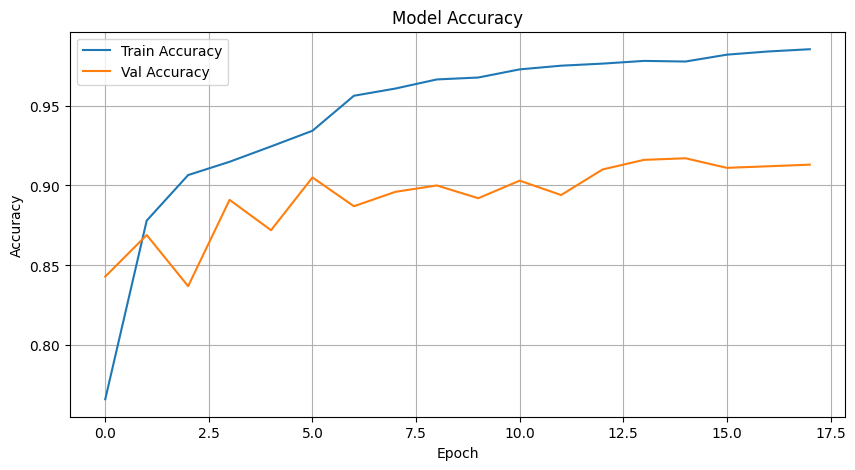

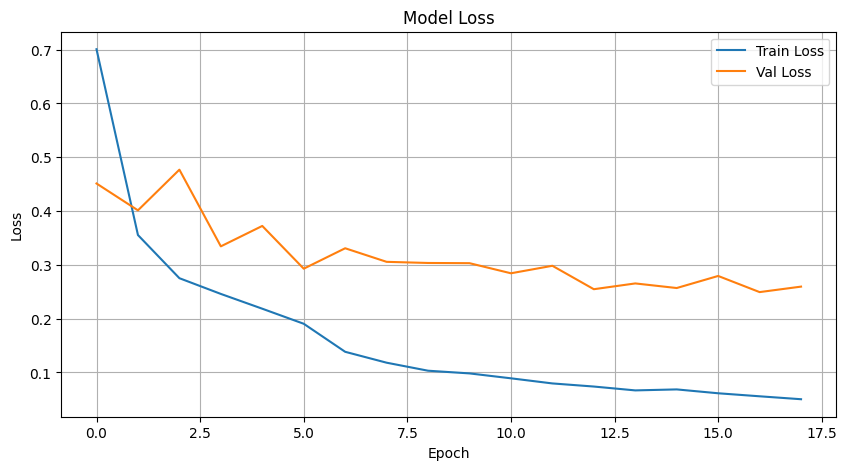

Best Val Accuracy: 0.9170 at epoch 15


In [10]:
def combine_history(h1, h2):
    history = {}
    for key in h1.history.keys():
        history[key] = h1.history[key] + h2.history.get(key, [])
    return history

full_history = combine_history(history_frozen, history_finetune)

plt.figure(figsize=(10, 5))
plt.plot(full_history["accuracy"], label="Train Accuracy")
plt.plot(full_history["val_accuracy"], label="Val Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(full_history["loss"], label="Train Loss")
plt.plot(full_history["val_loss"], label="Val Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

best_val_acc = max(full_history["val_accuracy"])
best_epoch = np.argmax(full_history["val_accuracy"]) + 1
print(f"Best Val Accuracy: {best_val_acc:.4f} at epoch {best_epoch}")


In [11]:
val_loss, val_acc = model.evaluate(val_ds)

print("Validation Accuracy:", val_acc)
print("Validation Loss:", val_loss)

32/32 [==============================] - 3s 87ms/step - loss: 0.2595 - accuracy: 0.9130
Validation Accuracy: 0.9129999876022339
Validation Loss: 0.25946804881095886


<Figure size 1000x1000 with 0 Axes>

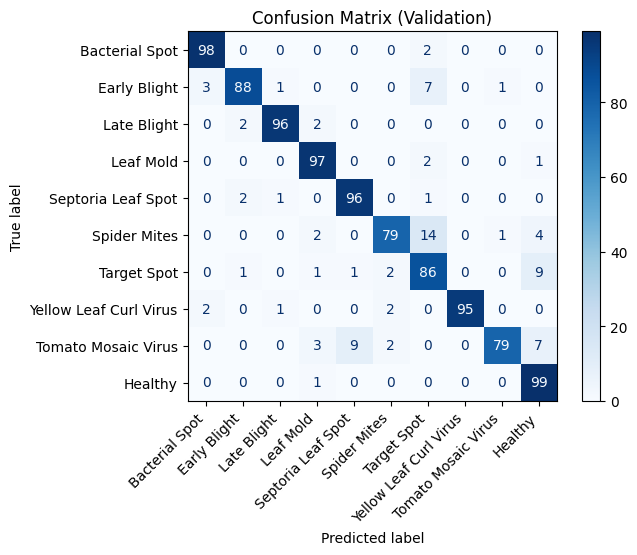

In [18]:
class_labels = [
    "Bacterial Spot",
    "Early Blight",
    "Late Blight",
    "Leaf Mold",
    "Septoria Leaf Spot",
    "Spider Mites",
    "Target Spot",
    "Yellow Leaf Curl Virus",
    "Tomato Mosaic Virus",
    "Healthy"
]

y_true = []
y_pred = []

for images, lbls in val_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(lbls.numpy(), axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 10))
disp.plot(cmap="Blues", values_format="d")
plt.xticks(rotation=45, ha='right')
plt.title("Confusion Matrix (Validation)")
plt.show()
